# ML4DS - Model Selection

## Introduction

We will explore the various options for model selection on a *clustering* task.
We will compare multiple methods for model selection on a real dataset, called digit from sklearn.

## Import Packages

In [71]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn import mixture
from sklearn.datasets import load_digits
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
import itertools
from scipy import linalg
from sklearn.metrics import silhouette_samples, silhouette_score
import pandas as pd
import itertools
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score


# Mixture Models

Statistical mixture models are somewhat related to K-means but place the clustering problem within a statistical framework.

We will use Gaussian mixtures: models in which data from each cluster is assumed to come from a different Gaussian. With mixture models we have two model selection challenges: choosing $K$ and choosing the form of the Gaussian covariance matrices:

- spherical: the covariance matrices are of the form $\sigma^2\mathbf{I}$ (where $\mathbf{I}$ is an identity), i.e. the variance is the same in all dimensions and there is no correlation structure
- diagonal: there is no correlation structure, but the variance can be different in each dimension
- tied: all Gaussians share the same covariance matrix
- full: each Gaussian can have a different covariance matrix that can have full correlation structure

See https://scikit-learn.org/stable/auto_examples/mixture/plot_gmm_covariances.html

To create a Gaussian mixture object using sklearn with (say) a tied covariance structure, use:

```{python}
from sklearn import mixture
gmm = mixture.Gaussian(n_components = K,covariance_type='cv_type')
```

__Note__
- the `mixture.Gaussian` object has methods to compute BIC and AIC (`gmm.bic(X)` etc)
- you can also perform cross validation with a mixture, but computing the likelihood on held-out observations. The likelihood is the standard mixture likelihood:

$L = \prod_n \sum_k \pi_k p(x_n|k)$

where the product is over the held-out data, the sum is over the clusters, $\pi_k$ is the prior weight of cluster k (`gmm.weights_`) and $p(x_n|k)$ is the Gaussian likelihood of the nth observation in the kth cluster.

### Load a real data set

In [72]:
digits = load_digits()
data = scale(digits.data)
n_samples, n_features = data.shape
n_digits = len(np.unique(digits.target))
labels = digits.target
y=labels

### Useful code to plot a single digit

In [73]:
# method to plot a single digit
def plot_digit(digit_data):
    im = plt.imshow(digit_data.reshape(8,8), cmap='binary')
    im.set_clim(0, 16)

# example - plot the third one in the dataset    
plot_digit(digits.data[3])

### Project the data into 2D

In [74]:
pca = PCA(n_components=2)
X = pca.fit_transform(data)
print('percentage of information conserved',sum(pca.explained_variance_ratio_),'%')

percentage of information conserved 0.21594970484080428 %


Text(0, 0.5, 'pca second component')

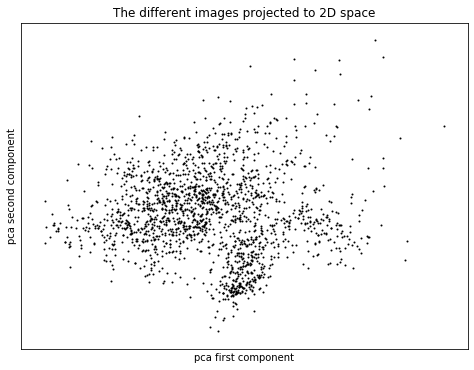

In [75]:
plt.figure(figsize=(8, 6))
plt.title("The different images projected to 2D space")
plt.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', markersize=2)
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.xlabel("pca first component")
plt.ylabel("pca second component")

## The task

Explore different model selection strategies to determine the number of clusters required for a Gaussian mixture clustering of this data (in the 2D PCA space) **and** the correct choice of covariance matrix structure (from the options listed above).

You should try multiple methods (BIC, AIC, Silhouette, and cross-validation)

Explore the clusterings suggested by each method, and look to see which digits are being grouped or split (if the optimal number is not 10 (digits 0-9).

The following method might be useful to plot the result of the clustering(s) and nice covariance ellipses

In [76]:
from matplotlib.patches import Ellipse
colors = ['navy', 'turquoise', 'darkorange','red','black','yellow','green','blue','orange','pink'] 
def make_ellipses(gmm, ax):
    for n, color in enumerate(colors[:gmm.n_components]):#use only n_components number of colors
        if gmm.covariance_type == 'full':
            covariances = gmm.covariances_[n][:2, :2]
        elif gmm.covariance_type == 'tied':
            covariances = gmm.covariances_[:2, :2]
        elif gmm.covariance_type == 'diag':
            covariances = np.diag(gmm.covariances_[n][:2])
        elif gmm.covariance_type == 'spherical':
            covariances = np.eye(gmm.means_.shape[1]) * gmm.covariances_[n]
        v, w = np.linalg.eigh(covariances)
        u = w[0] / np.linalg.norm(w[0])
        angle = np.arctan2(u[1], u[0])
        angle = 180 * angle / np.pi  # convert to degrees
        v = 2. * np.sqrt(2.) * np.sqrt(v)
        
        ell = mpl.patches.Ellipse(gmm.means_[n, :2],v[0], v[1],
                                  180 + angle, color=color)
        ell.set_clip_box(ax.bbox)
        ell.set_alpha(0.5)
        ax.add_artist(ell)
        ax.set_aspect('equal', 'datalim')        

In [77]:
#a function that takes as an argument the number of clusters, to cluster the data and utilizes all type of 
#covariance matrix for the training of the mixture model. Furthermore, it fits the data and tests the models
#using all metrics discussed. (BIC,AIC,silhouette score, accuracy, log-likelihood cross validation). These metrics
#are then returned as a dictionary.
def run_all_covariances(k=10):    
    estimators = {cov_type: mixture.GaussianMixture(n_components=k,
                  covariance_type=cov_type, max_iter=20000, random_state=0)
                  for cov_type in ['spherical', 'diag', 'tied', 'full']}    
    results=[]
    print('k =',k)
    for index, (name, estimator) in enumerate(estimators.items()):       
        # Train the other parameters using the EM algorithm.
        if(k<11):#for k<11 we can initiliaze the mixture model cluster mean center as the mean of the specific
            #digits over the data.
               estimator.means_init = np.array([X[y == i].mean(axis=0) for i in range(k)])
            
        estimator.fit(X)
        bic=estimator.bic(X)#the lower the better
        aic=estimator.aic(X)#the lower the better 
        y_train_pred = estimator.predict(X)
        sil=silhouette_score(X,y_train_pred)
        train_accuracy = accuracy_score(y_train_pred,y)       
        loss_cv=loss_over_cv(X,y,estimator,estimator.n_components)
        
        plt.figure(figsize=(6,4 ), dpi= 100, facecolor='w', edgecolor='k')
        plt.title('Covariance type : '+name+' with k='+str(k))

        for n, color in enumerate(colors[:k]):
            data = X[y_train_pred == n]            
            plt.scatter(data[:, 0], data[:, 1], color=color,s=1)       
        
        plt.xlabel("pca first component")
        plt.ylabel("pca second component")
        make_ellipses(estimator,plt.gca())    
        plt.show()
        results.append((bic,aic,sil,train_accuracy,loss_cv,name))

    return results

In [78]:
#function that runs cross validation using log-likelihood as a loss.
#log-likelihood is provided through the scores function of the mixture model.
def loss_over_cv(X,Y,estimator,k):
    cv = KFold(n_splits=10)
    loss_list=[]
    for train_index, test_index in cv.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        estimator.fit(X_train)
        loss_list.append(estimator.score(X_test))        
    return np.mean(loss_list)     

bic	 aic 	 silhouette 	 accuracy 	 loss_cv
lower 	 lower 	 close to 1 	 close to 1
k = 5


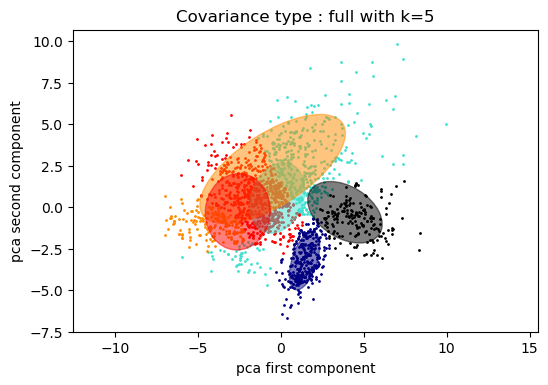

(16549.588631482482, 16445.205027633594, 0.30939869063031367, 0.2888146911519199, -4.606894338014589, 'spherical')
(16491.419351197015, 16359.566377914209, 0.3210983100586308, 0.32053422370617696, -4.606234558891203, 'diag')
(16705.562353267287, 16612.166497191967, 0.3042002182268807, 0.3266555370061213, -4.661000674428102, 'tied')
(16445.29594344923, 16285.973600732505, 0.3010185725289325, 0.3606010016694491, -4.56615846963898, 'full')
k = 6


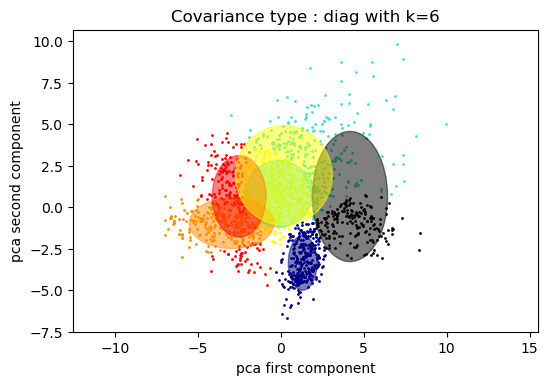

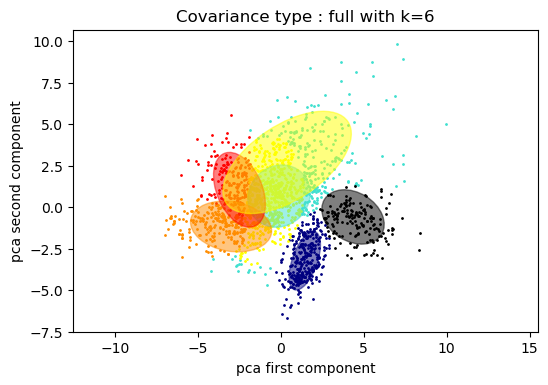

(16581.843473142664, 16455.484373746644, 0.3276743218969436, 0.32943795214245963, -4.6047756823346795, 'spherical')
(16513.284851524277, 16353.962508807552, 0.33001904958443495, 0.3578185865331107, -4.588899501583901, 'diag')
(16669.03269192125, 16559.15521418558, 0.2046424564746812, 0.32109070673344464, -4.647990272442504, 'tied')
(16473.29412761377, 16281.008541576348, 0.3169266339279682, 0.3850862548692265, -4.570551570713713, 'full')
k = 7


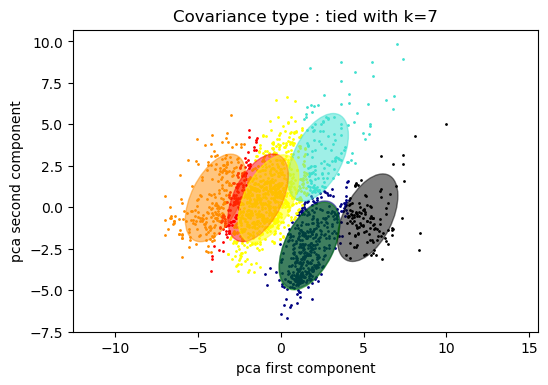

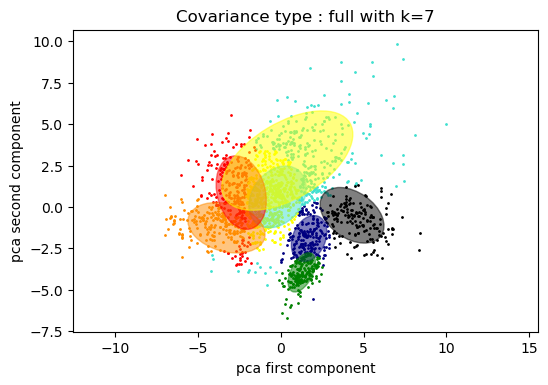

(16514.98396083783, 16366.649365894677, 0.3018028973031487, 0.42125765164162493, -4.58321047933176, 'spherical')
(16519.54940336752, 16332.757691216879, 0.2887625589412994, 0.42960489705064, -4.585041462996402, 'diag')
(16691.282221026588, 16564.923121630567, 0.21215469667187886, 0.3344462993878687, -4.653632304016502, 'tied')
(16503.438482699712, 16278.189653341587, 0.2888666121786255, 0.45798553144129106, -4.565644732556394, 'full')
k = 8


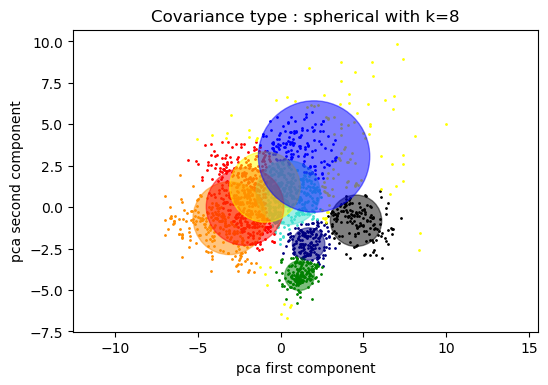

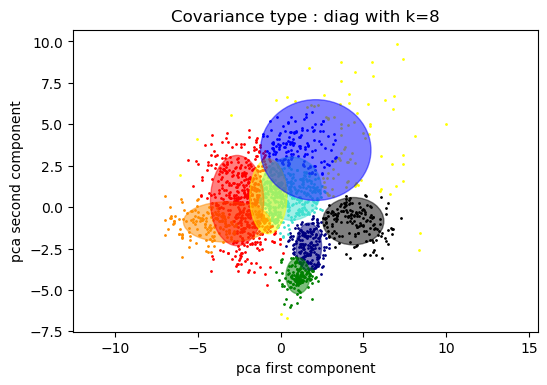

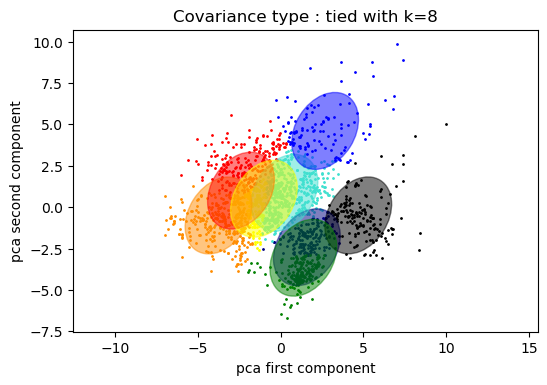

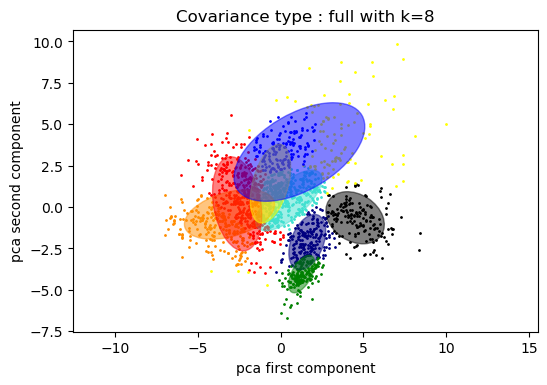

(16523.857757517064, 16353.547667026774, 0.2890152318872286, 0.4746800222593211, -4.586818982034943, 'spherical')
(16523.717390681664, 16309.456309097104, 0.2721599564476358, 0.4780189204229271, -4.582288973014138, 'diag')
(16736.993531797794, 16594.152810741423, 0.27089693956563593, 0.5008347245409015, -4.647994808968691, 'tied')
(16520.52745965604, 16262.315386977214, 0.31024047183347087, 0.5002782415136339, -4.575596639712788, 'full')
k = 9


(16537.044752606325, 16344.759166568901, 0.33725822485922524, 0.49638286032276013, -4.582004598422439, 'spherical')
(16556.865868305158, 16315.135417286681, 0.3149738381315181, 0.5036171396772399, -4.579545059790452, 'diag')
(16741.371985590653, 16582.049642873928, 0.26475791714017305, 0.5025041736227045, -4.643772982859772, 'tied')
(16556.23684600409, 16265.06153000456, 0.3254243482655951, 0.5230940456316082, -4.557150017392903, 'full')
k = 10


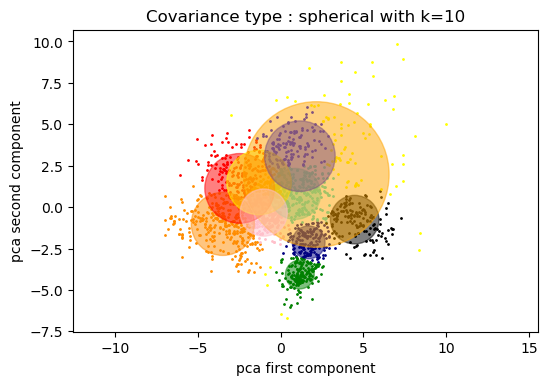

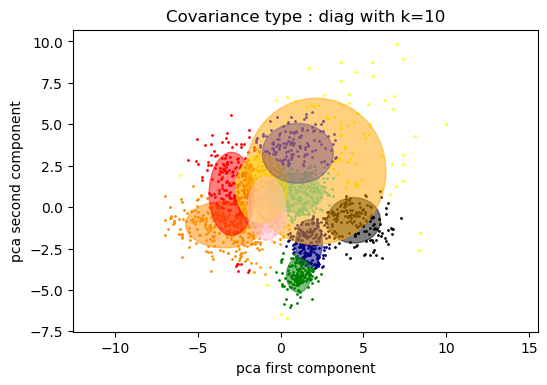

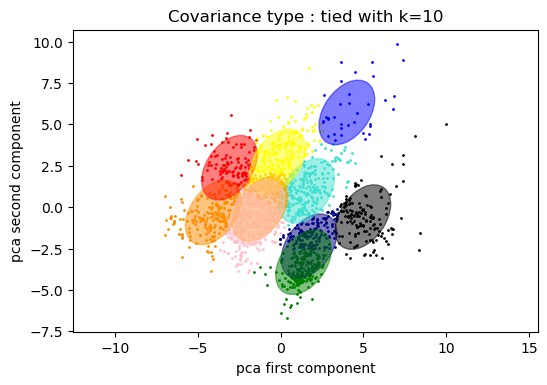

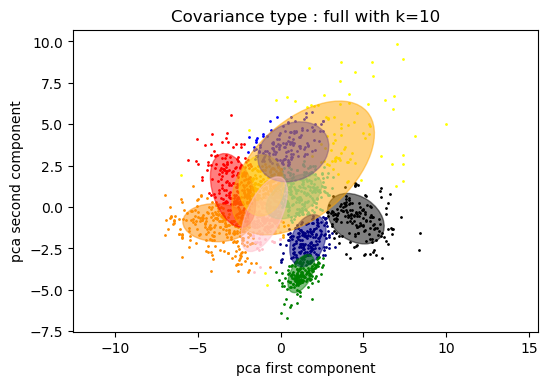

(16562.658830420212, 16348.397748835654, 0.30280746500910133, 0.5030606566499721, -4.585573616139228, 'spherical')
(16593.911288446576, 16324.711467994182, 0.29758883683441634, 0.5052865887590429, -4.580540445252824, 'diag')
(16662.60142671682, 16486.797462339746, 0.33010155152171466, 0.4741235392320534, -4.632656214281812, 'tied')
(16597.929780074985, 16273.791220754754, 0.3144502074864849, 0.530328324986088, -4.555813383166258, 'full')
k = 11


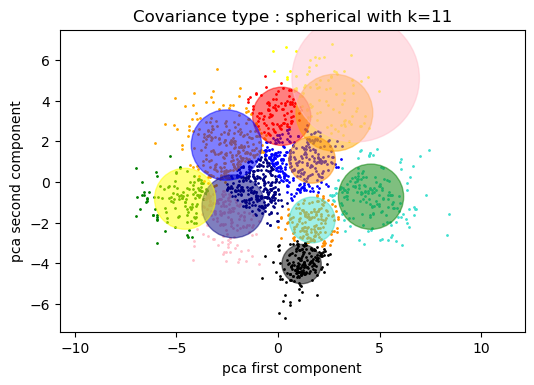

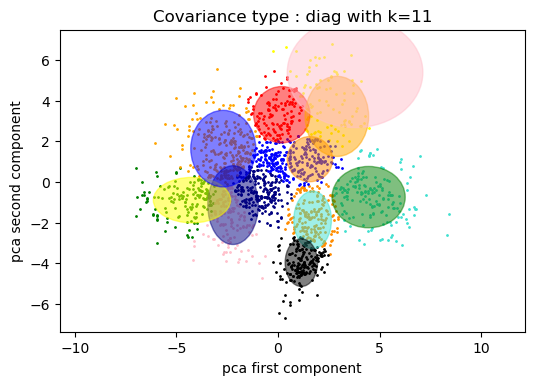

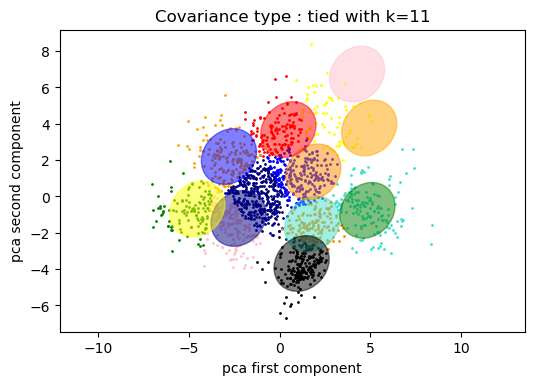

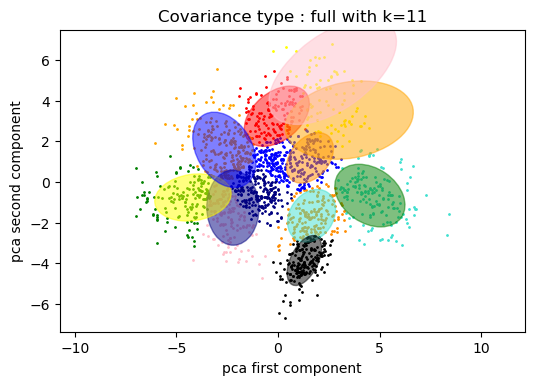

(16543.627244916792, 16307.390667785097, 0.3355393136995354, 0.05342237061769616, -4.5739624826862535, 'spherical')
(16579.626197321948, 16282.957007435634, 0.3465686526973022, 0.05063995548135782, -4.572138156070699, 'diag')
(16643.511874583946, 16451.22628854652, 0.3423771855752078, 0.04618809126321647, -4.617540424840433, 'tied')
(16617.01903366232, 16259.917231021387, 0.35025346035071947, 0.05063995548135782, -4.566538282853273, 'full')
k = 12


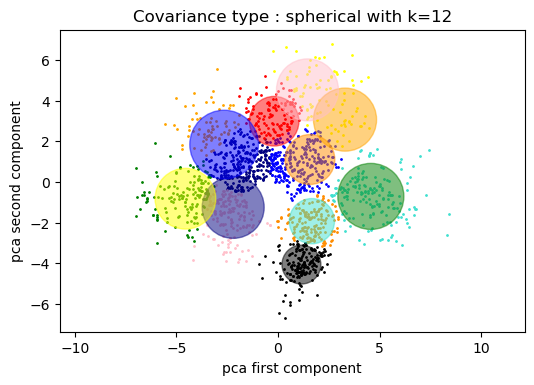

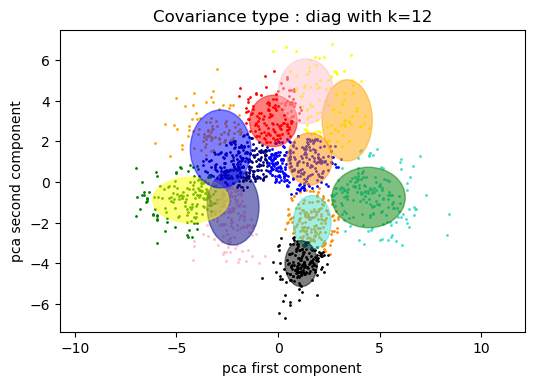

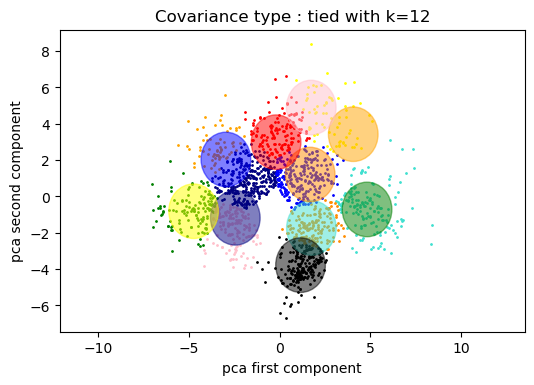

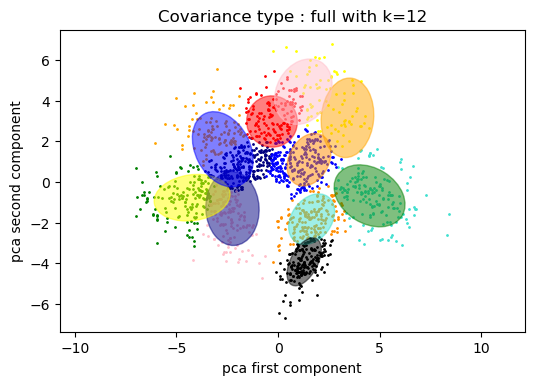

(16560.127513445594, 16301.915440766767, 0.3458022043611312, 0.038953811908736785, -4.577252253116752, 'spherical')
(16601.317301984527, 16277.178742664299, 0.3565238114707497, 0.038953811908736785, -4.572492772042045, 'diag')
(16656.82033670042, 16448.05312900265, 0.34847286812711564, 0.035058430717863104, -4.619662418769558, 'tied')
(16644.423276298105, 16254.358230336471, 0.3560896767637279, 0.038397328881469114, -4.567108964843028, 'full')


In [79]:
#showing the graph of our 2D projected data and how they are clustered using various number of clusters and 
#different covariance type. This could is only possible for 2D data and that is the reason we choose them as that.

print('bic\t aic \t silhouette \t accuracy \t loss_cv')
print('lower \t lower \t close to 1 \t close to 1')
results_for_all_k=[]
ks=[5,6,7,8,9,10,11,12]
for k in ks:
    res=(run_all_covariances(k))
    for r in res:
        print(r)
    results_for_all_k.append(res)    


In [80]:
#gathering all metrics in dictionaries for easy manipulation
AIC={}
BIC={}
silhouette_score1={}
accuracy={}
loss_cv={}
for r in range(0,len(results_for_all_k)):
    BIC[r+5]=[]
    AIC[r+5]=[]
    silhouette_score1[r+5]=[]
    accuracy[r+5]=[]
    loss_cv[r+5]=[]
    for cov in range(4):
        BIC[r+5].append(results_for_all_k[r][cov][0])
        AIC[r+5].append(results_for_all_k[r][cov][1])
        silhouette_score1[r+5].append(results_for_all_k[r][cov][2])
        accuracy[r+5].append(results_for_all_k[r][cov][3])
        loss_cv[r+5].append(results_for_all_k[r][cov][4])

spherical      diag      tied      full
Number of clusters                                         
5                   -4.606894 -4.606235 -4.661001 -4.566158
6                   -4.604776 -4.588900 -4.647990 -4.570552
7                   -4.583210 -4.585041 -4.653632 -4.565645
8                   -4.586819 -4.582289 -4.647995 -4.575597
9                   -4.582005 -4.579545 -4.643773 -4.557150
10                  -4.585574 -4.580540 -4.632656 -4.555813
11                  -4.573962 -4.572138 -4.617540 -4.566538
12                  -4.577252 -4.572493 -4.619662 -4.567109

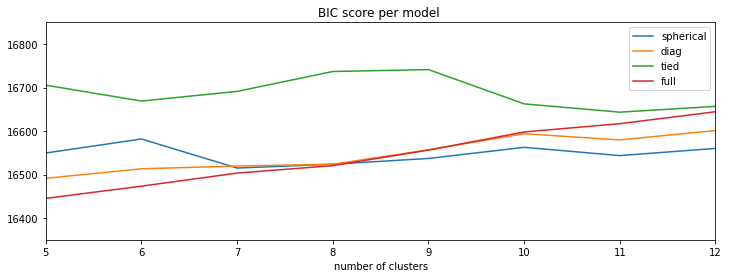

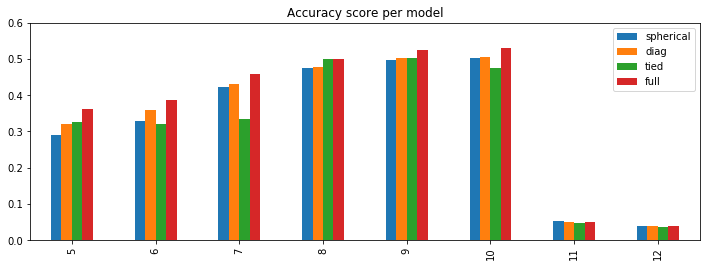

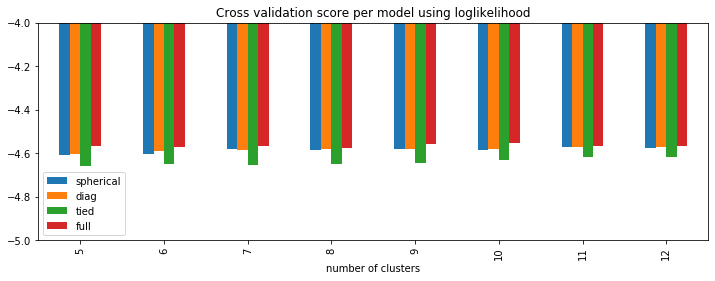

In [81]:
#separate each metric depended on the covariance type and show some figures and stats about their distributions.
bic_cov={'spherical':[],'diag': [],'tied':[],'full':[]}
aic_cov={'spherical':[],'diag': [],'tied':[],'full':[]}
sil_cov={'spherical':[],'diag': [],'tied':[],'full':[]}
accu_cov={'spherical':[],'diag': [],'tied':[],'full':[]}
loss_cv_cov={'spherical':[],'diag': [],'tied':[],'full':[]}

for i in AIC.values():
    aic_cov['spherical'].append(i[0])
    aic_cov['diag'].append(i[1])
    aic_cov['tied'].append(i[2])
    aic_cov['full'].append(i[3])

for i in BIC.values():
    bic_cov['spherical'].append(i[0])
    bic_cov['diag'].append(i[1])
    bic_cov['tied'].append(i[2])
    bic_cov['full'].append(i[3])
    
for i in silhouette_score1.values():
    sil_cov['spherical'].append(i[0])
    sil_cov['diag'].append(i[1])
    sil_cov['tied'].append(i[2])
    sil_cov['full'].append(i[3])
    
for i in accuracy.values():
    accu_cov['spherical'].append(i[0])
    accu_cov['diag'].append(i[1])
    accu_cov['tied'].append(i[2])
    accu_cov['full'].append(i[3])
for i in loss_cv.values():
    loss_cv_cov['spherical'].append(i[0])
    loss_cv_cov['diag'].append(i[1])
    loss_cv_cov['tied'].append(i[2])
    loss_cv_cov['full'].append(i[3])    
ks=[5,6,7,8,9,10,11,12]

cov_bic=pd.DataFrame(bic_cov)
ax=cov_bic.plot(ylim=((16350,16850)),title='BIC score per model ',figsize=(12,4))
ax.set_xticklabels(ks)
ax.set(xlabel='number of clusters')
ax.figure.savefig("cov_bic_line.png")

cov_bic=pd.DataFrame(bic_cov)
ax=cov_bic.plot(kind='bar',ylim=((16350,16850)),title='BIC score per model',figsize=(12,5))
ax.set_xticklabels(ks)
ax.set(xlabel='number of clusters')
ax.figure.savefig("cov_bic_bar.png")


cov_aic=pd.DataFrame(aic_cov)
ax=cov_aic.plot(kind='bar',ylim=((16200,16700)),title='AIC score per model',figsize=(12,4))
ax.set_xticklabels(ks)
ax.set(xlabel='number of clusters')
ax.figure.savefig("cov_aic_bar.png")


cov_sil=pd.DataFrame(sil_cov)
ax=cov_sil.plot(ylim=((0.2,.4)),title='Silhouette score per model',figsize=(12,4))
ax.set_xticklabels(ks)
ax.set(xlabel='number of clusters')
ax.figure.savefig("cov_sil_line.png")


cov_accu=pd.DataFrame(accu_cov)
ax=cov_accu.plot(kind='bar',ylim=((0,.6)),title='Accuracy score per model',figsize=(12,4))
ax.set_xticklabels(ks)
ax.figure.savefig("cov_accu_bar.png")


cov_loss_cv=pd.DataFrame(loss_cv_cov,index=ks)
ax=cov_loss_cv.plot(kind='bar',ylim=((-5,-4)),title='Cross validation score per model using loglikelihood',figsize=(12,4))
ax.set_xticklabels(ks)
ax.set(xlabel='number of clusters')
ax.figure.savefig("cov_loss_cv_bar.png")
print()
cov_loss_cv.index.name = 'Number of clusters'
cov_loss_cv

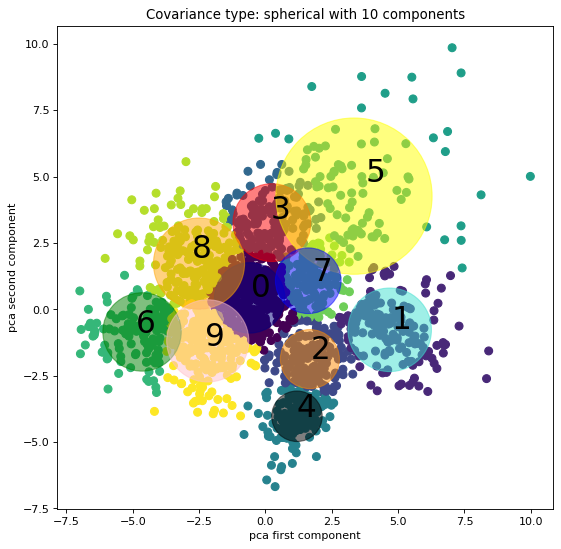

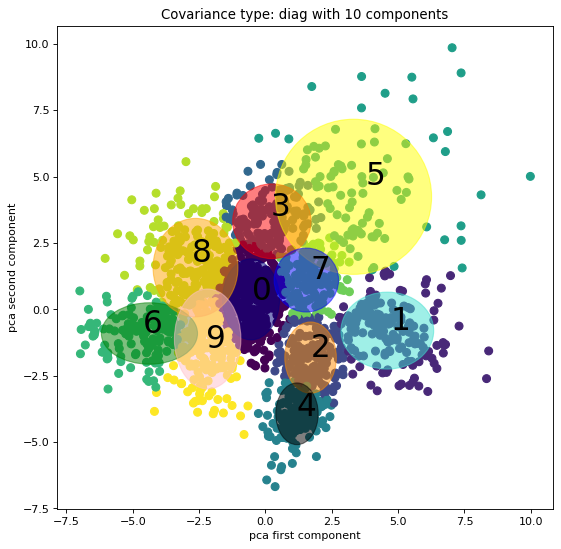

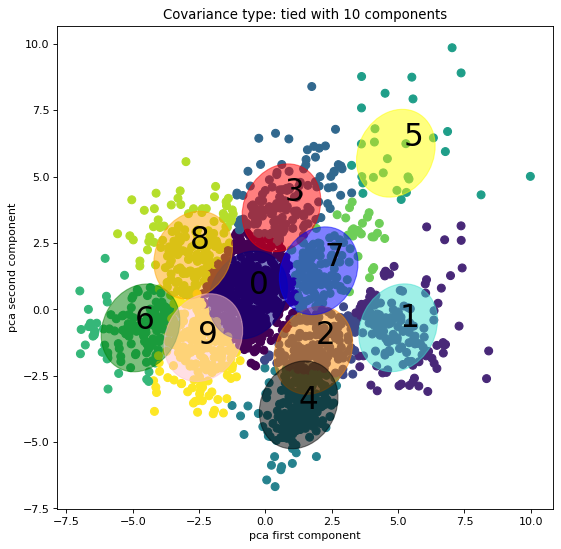

In [82]:
#Here we just show the difference results knowing that the clusters should be 10. Also each cluster's center is
#shown by the number (the position) which also is the cluster 'name' . ie cluster 7 corresponds to the digits 
#that are assigned as 7 etc.We can observe heavy overlapping between many clusters. Where we can assume that 
#those clusters are really close semantically. For example 1 and 7 are very similar.
k=10

for cov_type in ['spherical', 'diag', 'tied', 'full']:
    clf=mixture.GaussianMixture(n_components=k, covariance_type=cov_type, max_iter=200, random_state=0)
    clf.fit(X)
    preds=clf.predict(X)
    fig=plt.figure(figsize=(8, 8), dpi= 80, facecolor='w', edgecolor='k')
    plt.scatter(X[:, 0], X[:, 1], c=preds, s=50, cmap='viridis')
    plt.title('Covariance type: '+cov_type+' with 10 components')
    plt.xlabel("pca first component")
    plt.ylabel("pca second component")
    
    mean_pr={}
    mean_pr_num={}
    for i in range(0,10):
        mean_pr[i]=[0,0]
        mean_pr_num[i]=0
    for i in range(0,len(preds)):
        mean_pr[preds[i]]+=X[i]
        mean_pr_num[preds[i]]+=1
    for i in range(0,10):
        mean_pr[i]/=mean_pr_num[i]
    for i in range(10):
        plt.text(mean_pr[i][0],mean_pr[i][1],s="%d"%i,fontsize=28,color='black')
    make_ellipses(clf, plt.gca())  
    #plt.savefig('scatter_'+cov_type+"_10.png")



In [83]:
#here we can see the optimal model found and the clustering it creates. Furthermore, we print an array
#that shows the mispredictions of the model. For example in the first row (0), the digit 0 is predicted as digit 1
# 17 times,etc.
k=10
X1=X
gl=mixture.GaussianMixture(n_components=k,
                  covariance_type='full', max_iter=20000, random_state=0)
gl.means_init = np.array([X1[y == i].mean(axis=0)
                                    for i in range(k)])

gl.fit(X1)
pr=gl.predict(X1)
print(accuracy_score(pr,y))
ls=np.zeros((10,10))    
ind=[]
for i in range(len(X1)):
    if(pr[i]!=y[i]):
        ls[y[i],pr[i]]+=1
        ind.append((i,pr[i]))
frequency_of_wrong_clusters=pd.DataFrame(ls)   
frequency_of_wrong_clusters

0.530328324986088


0     1     2     3    4     5     6     7     8     9
0   0.0  17.0   1.0   0.0  9.0   0.0  25.0   0.0   0.0   2.0
1   0.0   0.0  20.0   0.0  0.0  12.0   0.0   3.0  25.0  29.0
2   0.0   8.0   0.0  23.0  0.0   1.0   0.0   1.0   5.0  10.0
3   2.0   1.0  56.0   0.0  0.0   2.0   0.0  12.0   7.0  14.0
4   6.0   8.0   0.0   2.0  0.0  14.0   0.0   0.0   1.0   0.0
5   4.0  27.0  10.0  58.0  1.0   0.0   0.0   8.0  37.0  37.0
6  28.0   0.0   0.0   0.0  1.0   0.0   0.0   0.0   0.0   0.0
7   0.0  18.0   0.0   9.0  0.0  36.0   0.0   0.0  10.0   1.0
8   1.0  47.0   8.0  24.0  0.0   0.0   0.0   2.0   0.0  45.0
9   1.0  13.0  27.0  29.0  0.0  18.0   0.0  12.0  16.0   0.0

prediction = 1
true       = 2


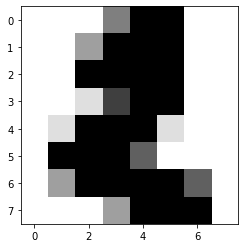

In [84]:
#Here it is clearly shown how easily a digit can be interpeted as another digit by humans. This problem is propagated
#also to the computer algorithms, thus increasing the errors.
index=0
plot_digit(digits.data[ind[index][0]]*2)
print('prediction =',ind[index][1])
print('true       =',digits.target[ind[index][0]])


In [85]:
#For the sake of comparison and compactness, we provide some results of accuracy and loglikelihood for a larger
#data dimension. 
pca = PCA(n_components=40)
X = pca.fit_transform(data)
print('percentage of information conserved',sum(pca.explained_variance_ratio_),'%')
k=10
train_len=int(len(X)*4/5)
X1=X[:train_len]
#covariance used 'tied' 
gl=mixture.GaussianMixture(n_components=k,covariance_type='tied', max_iter=20000, random_state=0)
gl.means_init = np.array([X[y == i].mean(axis=0) for i in range(k)])
gl.fit(X1)
pr=gl.predict(X[train_len:])
print()
print('tied covariance accuracy',accuracy_score(pr,y[train_len:]))
print('tied covariance cross validation log-likelihood',loss_over_cv(X,y,gl,10))
#covariance used 'full'
gl=mixture.GaussianMixture(n_components=k,covariance_type='full', max_iter=20000, random_state=0)
gl.means_init = np.array([X[y == i].mean(axis=0) for i in range(k)])
gl.fit(X1)
pr=gl.predict(X[train_len:])
print()
print('full covariance accuracy',accuracy_score(pr,y[train_len:]))
print('full covariance cross validation log-likelihood',loss_over_cv(X,y,gl,10))

percentage of information conserved 0.9507653802161109 %

tied covariance accuracy 0.8388888888888889
tied covariance cross validation log-likelihood -222.65276808612165

full covariance accuracy 0.19444444444444445
full covariance cross validation log-likelihood -6642.210086654692


From these results we can see that although in 2D full was found to be the optimal covariance type for our model, 
when we want to use more dimensions, the optimal model changes. There could be many reasons this happened.
For example, the parameters in the higher dimension model, as the log-likelihood says, did not fit the model good
enough, hence the large (negative) log-likelihood. On the other hand, as the other models are more simple
the parameters fitted better and have greater results than 'full'. This also demonstrates that more simple models
might generalize better in unknown data.